# 5章 顔類似画像検索

## 画像の準備

pexels-apiのインストール


In [1]:
!pip install pexels-api==1.0.1

ダウンロードするための関数

In [ ]:
import os

import requests
from pexels_api import API

PEXELS_API_KEY = 'ここにPEXELSのAPI KEYを入れてください'
api = API(PEXELS_API_KEY)

def save_file(filename, content):
    with open(filename, mode='wb') as f:
        f.write(content)
        print(f"save {filename}")

def download(keyword, page_start, page_end):
    os.makedirs("images", exist_ok=True)
    for page in range(page_start, page_end):
        results = api.search(keyword,
                             page=page,
                            results_per_page=50)
        photos = results['photos']
        for photo in photos:
            image_id = photo['id']
            image_url = photo['src']['medium']
            response = requests.get(image_url)
            filename = f"images/{image_id}.jpeg"
            save_file(filename, response.content)

faceでダウンロード

In [ ]:
download('face', 1, 30)

save images/775358.jpeg
save images/2709388.jpeg
save images/3680316.jpeg
save images/3586798.jpeg
save images/1933873.jpeg
save images/3671083.jpeg
save images/3310695.jpeg
save images/5119214.jpeg
save images/2846602.jpeg
save images/2922301.jpeg
save images/4890733.jpeg
save images/3220360.jpeg
save images/3283568.jpeg
save images/1840608.jpeg
save images/1858490.jpeg
save images/1982852.jpeg
save images/3981337.jpeg
save images/3533228.jpeg
save images/3748221.jpeg
save images/2741701.jpeg
save images/3186558.jpeg
save images/2530775.jpeg
save images/2466668.jpeg
save images/3438086.jpeg
save images/2755165.jpeg
save images/5397723.jpeg
save images/4229083.jpeg
save images/5046546.jpeg
save images/7564119.jpeg
save images/4556737.jpeg
save images/6015909.jpeg
save images/6652928.jpeg
save images/4355346.jpeg
save images/5034475.jpeg
save images/4993292.jpeg
save images/4662950.jpeg
save images/5704720.jpeg
save images/5704849.jpeg
save images/7402883.jpeg
save images/4571943.jpeg
s

ダウンロードした画像の枚数

In [ ]:
!ls -lh images | wc -l

1451


## 特徴抽出

### miraを試す

miraのインストール 

v0.5系で大きなAPIの変更があったため、v0.4の指定が必要になります。

In [ ]:
!pip install mira==0.4

画像のロードと表示

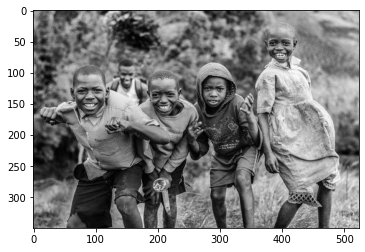

In [ ]:
from mira import core

image = core.Image.read("images/1002061.jpeg")
image.show()

顔領域の検出

In [ ]:
from mira import detectors
detector = detectors.MTCNN()
annotations = detector.detect(image)

アノテーション情報を可視化

/usr/local/lib/python3.7/dist-packages/mira/core/scene.py:209: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  bbox_inches='tight')


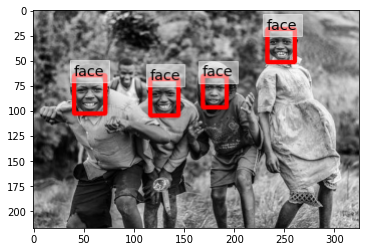

In [ ]:
scene = core.Scene(
    annotations=annotations,
    image=image,
    annotation_config=detector.annotation_config
)
scene.show()

顔領域を切り取る

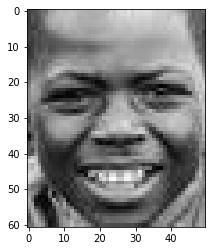

In [ ]:
annotation = annotations[0]
cropped = annotation.selection.extract(image)
cropped.show()

keras_facenetをインストール

In [ ]:
!pip install keras_facenet

     |████████████████████████████████| 2.3MB 7.4MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-cp37-none-any.whl size=10386 sha256=238ed25b6d529f6f110d50330401dbb3fc944085113178f39018200c367d617b
  Stored in directory: /root/.cache/pip/wheels/f6/53/9a/36c4b52fd22faf4f710d5047d874655b85a1b2cf77accfb9bd
Successfully built keras-facenet


### インデックス作成

画像のロード

In [ ]:
import pathlib
dir_path = "/content/images/"
image_path_list = []
for img_path in pathlib.Path(dir_path).glob("*.jpeg"):
    image_path_list.append(img_path)
image_path_list.sort()

画像の特徴抽出

In [ ]:
import numpy as np
from keras_facenet import FaceNet
from mira import core, detectors

detector = detectors.MTCNN()
embedder = FaceNet()

features = []
index_image_list = []
index_face_list = []
for image_path in image_path_list:
    image = core.Image.read(str(image_path))
    faces = detector.detect(image)
    if not faces:
        print("not detect face", image_path)
        continue
    face = max(
      faces,
      key=lambda face: face.selection.area())
    cropped_face = face.selection.extract(image)
    embeddings = embedder.embeddings([cropped_face])
    features.append(embeddings[0])
    index_image_list.append(image_path)
    index_face_list.append(face)

features = np.array(features)    

not detect face /content/images/1022158.jpeg
not detect face /content/images/1022166.jpeg
not detect face /content/images/1033797.jpeg
not detect face /content/images/1035685.jpeg
not detect face /content/images/106685.jpeg
not detect face /content/images/1082256.jpeg
not detect face /content/images/1105191.jpeg
not detect face /content/images/1138155.jpeg
not detect face /content/images/1138531.jpeg
not detect face /content/images/1149022.jpeg
not detect face /content/images/1161267.jpeg
not detect face /content/images/1201758.jpeg
not detect face /content/images/1202025.jpeg
not detect face /content/images/1209843.jpeg
not detect face /content/images/1251247.jpeg
not detect face /content/images/1264442.jpeg
not detect face /content/images/133408.jpeg
not detect face /content/images/1358845.jpeg
not detect face /content/images/1399073.jpeg
not detect face /content/images/1406722.jpeg
not detect face /content/images/1424981.jpeg
not detect face /content/images/1435517.jpeg
not detect f

## 検索ロジックの作成

In [ ]:
def distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def get_top_n_indexes(vec, num):
    idx = np.argpartition(vec, -num)[-num:]
    return idx[np.argsort(vec[idx])][::-1]


def search_by_distance(query_feature, features, num):
    distances = []
    for feature in features:
      d = distance(feature, query_feature)
      distances.append(d)
    distances = np.array(distances)
    indexes = get_top_n_indexes(-distances, num)
    return indexes, distances[indexes]    

## 検索

In [ ]:
query = 0
results, distances = search_by_distance(features[query], features, 9)

## 可視化

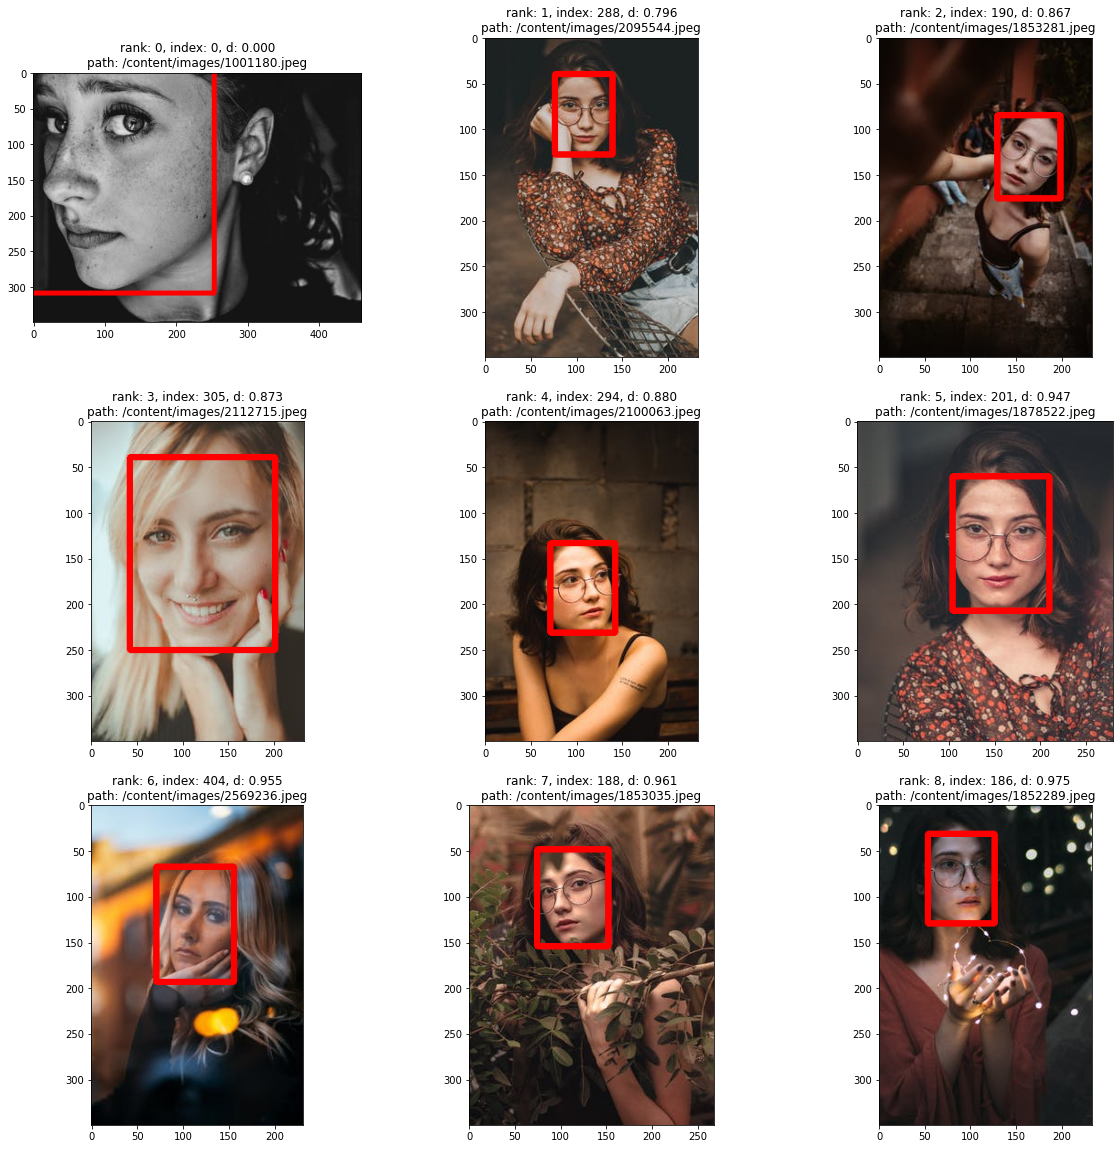

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
red = (255, 0, 0)

rank = 0
for idx, d in zip(results, distances):
    plt.subplot(3, 3, rank+1)
    path = index_image_list[idx]
    title = f"rank: {rank}, index: {idx}, d: {d:.3f}\n"
    title += f"path: {path}"
    plt.title(title)
    image = core.Image.read(str(path))
    face = index_face_list[idx]
    cropped = face.selection.draw(image, red)
    plt.imshow(cropped)
    rank += 1